# Code for the project in "Modélisation en neurosciences et ailleurs" class (MVA 2018-2019) by Clémence Réda

This notebook aims at extending and analyzing the results in the paper "**Modern Machine Learning as
a Benchmark for Fitting Neural Responses**" [Benjamin et al., 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6060269/pdf/fncom-12-00056.pdf). I will proceed as follows:

+ I will test the Poisson assumption of the neuron spiking statistics on several datasets.
+ I will try to reproduce the results of the paper (comparison between GLM, Feedforward neural network, Gradient-boosted trees) on other datasets from another lab, in order to externally validate the results of the paper.

All code except for this notebook has been written by Benjamin and collaborators, and has been made available at this [repository](https://github.com/KordingLab/spykesML).


## Libraries and modules

In [1]:
import warnings

import numpy as np
import pandas as pd
import scipy
import scipy.io

##### Load encoding package (file *mlencoding.py* from the GitHub of the authors of the paper)

In [2]:
from mlencoding import *

Using TensorFlow backend.


# 0. Statistics of spiking neurons

I would like to assess the similarity of the distribution of spiking neurons with Poisson distributions, since it is a common assumption in the field. I will use the following datasets:

+ Two datasets ([Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream), from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short), and [Rhesus Macaque S1](https://github.com/KordingLab/spykesML), from [Benjamin et al., 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6060269/pdf/fncom-12-00056.pdf)) used in the paper. Time-windows were set at 50 ms. The experiments were center-out reaching tasks.
+ [Monkey V1](http://bethgelab.org/datasets/v1gratings/) from the Bethge Lab, which were used in the following papers ([1](http://bethgelab.org/media/publications/EckerEtAl2010_all.pdf), [2](http://bethgelab.org/media/publications/BerensEtAl2012.pdf)). Monkey brain activity in the visual cortex was monitored while the animals watched static gratings, or moving gratings in the direction orthogonal to their orientation. Time-windows were set at 10 ms.

### Loading datasets

#### Macaque M1

This set is the one on which the authors performed their analysis. Figures in the paper relate to this dataset.

I keep the same set of covariates used in the paper from [Benjamin et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6060269/pdf/fncom-12-00056.pdf), that is, for every spike, the time bin, the hand position ($x$, $y$), the hand velocity ($x^.$, $y^.$), the hand direction $\theta_p$, the velocity direction $\theta_v$ (and the associated cosine functions), and usual hand-crafted features: the speed $\sqrt{x^{.2}+y^{.2}}$ and the radial position $\sqrt{x^2+y^2}$.

Spikes are stored in a matrix *spikes_M1* of size $n \times T$, where $n$ is the number of monitored neurons, and $T$ the number of time bins. The coefficient *spikes_M1[i,j]* is the spike count in time bin $j$ in neuron $i$.

In [3]:
m1_imported = scipy.io.loadmat('../data/m1_stevenson_2011.mat')
data_m1 = pd.DataFrame()
data_m1['time'] =  m1_imported['time'][0]
data_m1['handPos_x'] =  m1_imported['handPos'][0]
data_m1['handPos_y'] =  m1_imported['handPos'][1]
data_m1['handVel_x'] =  m1_imported['handVel'][0]
data_m1['handVel_y'] =  m1_imported['handVel'][1]
#data_m1['spikes'] =  m1_imported['spikes'][0]
## Covariates from the paper and notebook of the authors
data_m1['velDir'] = np.arctan2(data_m1['handVel_y'], data_m1['handVel_x'])
data_m1['cos_velDir'] = np.cos(data_m1['velDir'])
data_m1['sin_velDir'] = np.sin(data_m1['velDir'])
data_m1['speed'] = np.sqrt(data_m1['handVel_x'].values**2
                           +data_m1['handVel_y'].values**2)
r = np.arctan2(data_m1['handPos_y'], data_m1['handPos_x'])
data_m1['cos_PosDir'] = np.cos(r)
data_m1['sin_PosDir'] = np.sin(r)
data_m1['radial_Pos'] = np.sqrt(data_m1['handPos_x'].values**2
                                +data_m1['handPos_y'].values**2)
data_m1.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,12.591,0.002905,-0.303636,-0.011201,-0.006237,-2.633523,-0.873685,-0.486491,0.012820,0.009568,-0.999954,0.303650
1,12.641,0.002260,-0.303869,-0.010743,-0.000833,-3.064245,-0.997010,-0.077271,0.010775,0.007437,-0.999972,0.303877
2,12.691,0.002399,-0.303631,0.017680,0.012094,0.599956,0.825360,0.564606,0.021420,0.007900,-0.999969,0.303641
3,12.741,0.004010,-0.302399,0.044667,0.038700,0.713933,0.755792,0.654812,0.059100,0.013258,-0.999912,0.302426
4,12.791,0.006386,-0.300673,0.042202,0.017021,0.383375,0.927408,0.374053,0.045505,0.021233,-0.999775,0.300741


In [4]:
spikes_M1 = m1_imported['spikes']
nN, nT = np.shape(spikes_M1)
print("There are " + str(nN) + " neurons and " + str(nT) + " time bins.")

There are 171 neurons and 15536 time bins.


#### Macaque S1

I keep the same set of covariates used in the paper from [Benjamin et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6060269/pdf/fncom-12-00056.pdf), that is, for every spike, the time bin, the hand position ($x$, $y$), the hand velocity ($x^.$, $y^.$), the hand direction $\theta_p$, the velocity direction $\theta_v$ (and the associated cosine functions), and usual hand-crafted features: the speed $\sqrt{x^{.2}+y^{.2}}$ and the radial position $\sqrt{x^2+y^2}$.

Spikes are stored in a matrix *spikes_S1* of size $n \times T$, where $n$ is the number of monitored neurons, and $T$ the number of time bins. The coefficient *spikes_S1[i,j]* is the spike count in time bin $j$ in neuron $i$.

In [5]:
s1_imported = scipy.io.loadmat('../data/s1_data.mat')
data_s1 = pd.DataFrame()
data_s1['handPos_x'] =  s1_imported['pos'].T[0]
data_s1['handPos_y'] =  s1_imported['pos'].T[1]
data_s1['handVel_x'] =  s1_imported['vel'].T[0]
data_s1['handVel_y'] =  s1_imported['vel'].T[1]
#data_s1['spikes'] =  s1_imported['spikes'][0]
data_s1['velDir'] = np.arctan2(data_s1['handVel_y'], data_s1['handVel_x'])
data_s1['cos_velDir'] = np.cos(data_s1['velDir'])
data_s1['sin_velDir'] = np.sin(data_s1['velDir'])
data_s1['speed'] = np.sqrt(data_s1['handVel_x'].values**2
                           +data_s1['handVel_y'].values**2)
r = np.arctan2(data_s1['handPos_y'], data_s1['handPos_x'])
data_s1['cos_PosDir'] = np.cos(r)
data_s1['sin_PosDir'] = np.sin(r)
data_s1['radial_Pos'] = np.sqrt(data_s1['handPos_x'].values**2
                                +data_s1['handPos_y'].values**2)
data_s1.head()

,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,-0.416665,-31.236861,0.151037,0.150915,0.784996,0.707391,0.706822,0.213513,-0.013338,-0.999911,31.239640
1,-0.415795,-31.229589,-0.139471,0.110104,2.473325,-0.784897,0.619627,0.177693,-0.013313,-0.999911,31.232357
2,-0.428036,-31.237258,-0.355766,-0.396426,-2.302191,-0.667908,-0.744244,0.532656,-0.013701,-0.999906,31.240190
3,-0.444485,-31.255078,-0.243318,-0.276757,-2.291986,-0.660279,-0.751021,0.368508,-0.014220,-0.999899,31.258238
4,-0.449801,-31.253792,0.026628,0.287968,1.478588,0.092077,0.995752,0.289196,-0.014390,-0.999896,31.257029


In [6]:
spikes_S1 = s1_imported['spikes']
nN, nT = np.shape(spikes_S1)
print("There are " + str(nN) + " neurons and " + str(nT) + " time bins.")

There are 35129 neurons and 52 time bins.


#### Monkey V1

The potential covariates are the (Michelson) contrast of the gratings (nonnegative integer numbers comprised between $0$ and $1$), the direction of the gratings in degrees (nonnegative integer numbers comprised between $0$ and $360$: in order to obtain the orientation of the gratings, one should substract $90$ modulo $360$).

Given a considered single unit (the authors have ruled out cells which were not well-isolated, with more than $5$% of contamination) and a monkey, spikes are stored in a matrix *spikes_V1* of size $n \times T$, where $n$ is the number of conditions (for the grating experiment), and $T$ the number of time bins. The coefficient *spikes_V1[i,j]* is the spike count in time bin $j$ in condition $i$.

In [7]:
v1_grating_moving = scipy.io.loadmat("../data/bethge_lab_moving.mat")
v1_grating_static = scipy.io.loadmat("../data/bethge_lab_static.mat")

## Some data reformatting

to_1D = lambda x : x.T.tolist()[0]

def extract_spikes(resmat, subject=0, unit=0):
    data_list, spikes_list = [], []
    N = max(np.shape(resmat["data"][:, 0]))
    ## Index of selected monkey subject
    i = max(0, min(subject, N-1))
    ## Conditions for the grating experiment
    data = pd.DataFrame()
    data_mat = np.matrix(list(map(lambda x : list(map(float, x)), 
                                  resmat["data"][:, 0][i][0][0][2].flatten())))
    data["contrast"] = to_1D(data_mat[:, 0])
    data["direction"] = to_1D(data_mat[:, 1])
    ## Spike data (binned spikes)
    ## single units x conditions x time bins x repetitions
    ns, nc, nt, _ = np.shape(resmat["data"][:, 0][i][0][0][5])
    ## Index of selected single unit
    unit = max(0, min(unit, ns-1))
    spikes = np.zeros((nc, nt))
    for c in range(nc):
        ## Spike counts
        spikes[c, :] = np.sum(resmat["data"][:, 0][i][0][0][5][unit][c], axis=1)
    return data, spikes

data_V1m, spikes_V1m = extract_spikes(v1_grating_moving, subject=1, unit=0)
data_V1s, spikes_V1s = extract_spikes(v1_grating_static, subject=1, unit=0)

data_V1m.head()

,contrast,direction
0,100.0,0.0
1,100.0,22.5
2,100.0,45.0
3,100.0,67.5
4,100.0,90.0


In [8]:
data_V1s.head()

,contrast,direction
0,1.0,0.0
1,10.0,0.0
2,1.0,22.5
3,10.0,22.5
4,1.0,45.0


#### Testing the Poisson statistics assumption

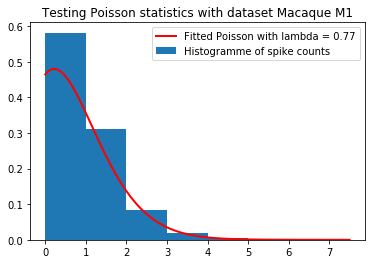

Remove categories from test: [3, 4]
Goodness-of-fit (Pearson's chi square test): p-value = 2.95158847686e-10


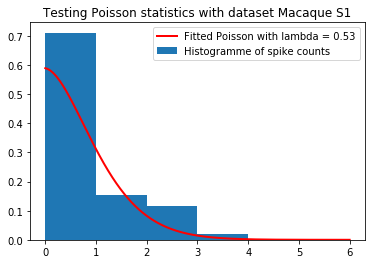

Remove categories from test: [3]
Goodness-of-fit (Pearson's chi square test): p-value = 1.76222193939e-28


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


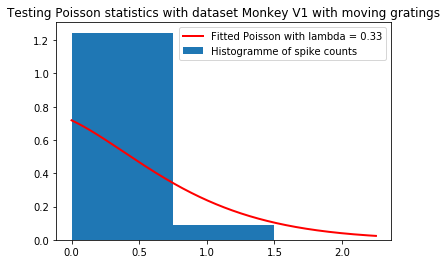

Goodness-of-fit (Pearson's chi square test): p-value = 5.43234714179e-54


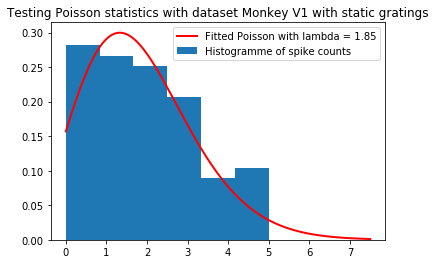

Goodness-of-fit (Pearson's chi square test): p-value = 0.000107327343835


In [23]:
## Check the form of the spike statistics for every of the four datasets above

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import chisquare, poisson

neuron_ID = 0

## Generalized linear model
def poisson_regression(X, Y):
    logY = np.log(Y)
    print(logY)
    print(X)
    beta = np.linalg.lstsq(np.matrix(X), logY)
    lbd = np.exp(X.dot(beta))
    return lbd

m1_spikes = spikes_M1[neuron_ID]
s1_spikes = spikes_S1[neuron_ID]
s_spikes = spikes_V1m[neuron_ID]
m_spikes = spikes_V1s[neuron_ID]

def poisson_pdf(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

## Source: https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram
def fit_poisson(data, title, nbins, range_):
        n = 100
        ## The y-axis of the histogram is a probability
        entries, bin_edges, patches = plt.hist(data, bins=nbins, 
                                               density=True, range=range_)
        bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
        parameters, cov_matrix = curve_fit(poisson_pdf, bin_middles, entries) 
        x_plot = np.linspace(range_[0], range_[1]*1.5, 1000)
        plt.plot(x_plot, poisson_pdf(x_plot, *parameters), 'r-', lw=2)
        plt.title("Testing Poisson statistics with dataset " + title)
        plt.legend(["Fitted Poisson with lambda = " + str(round(parameters[0], 2)),
                    "Histogramme of spike counts"])
        plt.show()
        ntry = 1000
        ## Expected frequencies (between 0 and 100)
        f_exp = [sum([poisson_pdf(b, parameters[0])*n for _ in range(ntry)])/float(ntry)
                 for b in bin_edges[1:]]
        entries = list(map(lambda x : x*n, entries))
        ## Chi-square can be applied only if all observed categories have count > 5
        remove_idx = list(filter(lambda i : entries[i] < 5, range(len(entries))))
        if (len(remove_idx) > 0):
            print("Remove categories from test: " + str(remove_idx))
        entries = list(filter(lambda x :x , 
                              [entries[i] if (i not in remove_idx) else None 
                               for i in range(len(entries))]))
        f_exp = list(filter(lambda x:x, [f_exp[i] if (i not in remove_idx)
                                         else None for i in range(len(entries))]))
        cs = chisquare(entries, f_exp=f_exp)
        print("Goodness-of-fit (Pearson's chi square test): p-value = " 
              + str(cs.pvalue))

fit_poisson(m1_spikes, title="Macaque M1", nbins=5, range_=[0., 5.0])
fit_poisson(s1_spikes, title="Macaque S1", nbins=4, range_=[0., 4.0])
fit_poisson(m_spikes, title="Monkey V1 with moving gratings", nbins=2, 
            range_=[0., 1.5])
fit_poisson(s_spikes, title="Monkey V1 with static gratings", nbins=6, 
            range_=[0., 5.0])

Assuming a standard p-value threshold of $0.05$ (probability of $5$% of incorrectly rejecting the null hypothesis), the null hypothesis "the empirical distribution of spike counts is a Poisson distribution" is rejected in all datasets.

It might be due to the fact that neuron spiking is not a proper Poisson process:

+ There is some type of memory of previous spikes: with, on the one hand, if we look at neuron populations, the phenomenon of "synaptic plasticity", where connections between neurons become stronger as the two neurons are fired together, and, on the other hand, when we focus on individual cells, the existence of the refractory period, that is, the period of neuron inactivity after a spike. 
+ It might be due to the fact that all datasets were recorded during experiments when there was an external stimulus (thus, the spike counts recorded are not a "spontaneous" event, but are induced by the stimuli). Thus, the firing rate of a cell might not be time-homogenous. In class, we saw a simple neuron spiking model, where the firing rate was a function of the time as well as of the stimulus. Here, I have tried to fit a homogenous Poisson distribution to the data.

# 1. Replication of the results in the paper with the new datasets

In [19]:
glm_model = MLencoding(tunemodel = 'glm')

## Finetuning parameters for GLM
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4glm = {
    'learning_rate': hp.uniform('learning_rate', 0.1, 3),
    'eta': hp.uniform('eta', 0.1, 3),
}

#function to minimize
def fnc_glm(params, X, y):
    glm_model.set_params(params)
    Y_hat, PR2s = glm_model.fit_cv(X,y, n_cv = 5, verbose = 0)
    return -np.mean(PR2s)

In [20]:
nn_model = MLencoding(tunemodel = 'feedforward_nn')

## Finetuning parameters for NN
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4nn = {
    'dropout': hp.uniform('dropout', 0., 0.6),
    'n1': hp.uniform('n1', 2,128),
    'n2': hp.uniform('n2', 1,15),
}

#function to minimize
def fnc_nn(params, X, y):
    ## Size of each of the two layers of the network (see mlencoding.py)
    params['n1'] = int(params['n1'])
    params['n2'] = int(params['n2'])
    nn_model.set_params(params)
    Y_hat, PR2s = nn_model.fit_cv(X,y, n_cv = 5, verbose = 0)
    return -np.mean(PR2s)

In [21]:
xgboost_model = MLencoding(tunemodel = 'xgboost', window = 50, n_filters = 2,
                           max_time = 250)

## Finetuning parameters for XGboost
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4xgboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'gamma': hp.uniform('eta', 0.1, 1.0),
}

#function to minimize
def fnc_xgb(params, X, y):
    xgboost_model.set_params(params)
    Y_hat, PR2s = xgboost_model.fit_cv(X,y, n_cv = 5, verbose = 0)
    return -np.mean(PR2s)

In [32]:
neuron_n = 0

X_M1 = data_m1[['handPos_x','handPos_y','handVel_x','handVel_y']].values
y_M1 = spikes_M1[neuron_n]
X_S1 = data_s1[['handPos_x','handPos_y','handVel_x','handVel_y']].values
y_S1 = spikes_S1[neuron_n]
X_V1m = data_V1m[['contrast','direction']].values
y_V1m = spikes_V1m[neuron_n]
X_V1s = data_V1s[['contrast','direction']].values
y_V1s = spikes_V1s[neuron_n]

In [ ]:
## For each method and each dataset, record the mean pseudo R^2 value
## and the confidence interval
PR2_values = np.zeros((3, 3, 2))
K = 5 # crossvalidation folds
max_evals=10

def results(i):
    print("----------- Dataset #" + str(i+1))
    if (i==0):
        X, y = X_M1, y_M1
    if (i==1):
        X, y = X_S1, y_S1
    if (i==2):
        X, y = X_V1m, y_V1m
    if (i==3):
        X, y = X_V1s, y_V1s
    if (i < 0 or i > 3):
        raise ValueError
    print("----------- GLM")
    trials = Trials() #for hyperparameter search
    hyperoptBest = fmin(lambda params : fnc_glm(params, X, y), 
                        space4glm, algo=tpe.suggest, 
                       max_evals=max_evals, trials=trials)
    print(hyperoptBest)
    glm_model.set_params(hyperoptBest)
    _, PR2s = glm_model.fit_cv(X, y, n_cv = K, verbose = 2)
    PR2_values[i, 0, :] = [np.mean(PR2s), np.std(PR2s)/np.sqrt(K)]
    print("----------- FEEDFORWARD NEURAL NETWORK")
    trials = Trials() #for hyperparameter search
    hyperoptBest = fmin(lambda params : fnc_nn(params, X, y), 
                        space4nn, algo=tpe.suggest, 
                        max_evals=max_evals, trials=trials)
    print(hyperoptBest)
    nn_model.set_params({'n1': int(hyperoptBest["n1"]), 'dropout': hyperoptBest["dropout"], 
                         'n2': int(hyperoptBest["n2"])})
    _, PR2s = nn_model.fit_cv(X,y, n_cv = K, verbose = 2)
    PR2_values[i, 1, :] = [np.mean(PR2s), np.std(PR2s)/np.sqrt(K)]
    print("----------- XGBOOST")
    trials = Trials() #for hyperparameter search
    hyperoptBest = fmin(lambda params : fnc_xgb(params, X, y), 
                        space4xgboost, algo=tpe.suggest, 
                        max_evals=max_evals, trials=trials)
    print(hyperoptBest)
    xgboost_model.set_params(hyperoptBest)
    _, PR2s = xgboost_model.fit_cv(X,y, n_cv = K, verbose = 2)
    PR2_values[i, 2, :] = [np.mean(PR2s), np.std(PR2s)/np.sqrt(K)]
    
results(0)

----------- Dataset #1
----------- GLM
100%|██████████| 10/10 [07:52<00:00, 42.31s/it, best loss: -0.0198458099128]
{'learning_rate': 2.971686123681141, 'eta': 2.5797169040256285}
('...runnning cv-fold', 1, 'of', 5)
('pR2: ', 0.017126228740941274)
('...runnning cv-fold', 2, 'of', 5)
('pR2: ', 0.028805402405215452)
('...runnning cv-fold', 3, 'of', 5)
('pR2: ', 0.017547008507770356)
('...runnning cv-fold', 4, 'of', 5)
('pR2: ', 0.020179465803447538)
('...runnning cv-fold', 5, 'of', 5)
('pR2: ', 0.015570944106404139)
pR2_cv: 0.019846 (+/- 0.002110)
----------- FEEDFORWARD NEURAL NETWORK
 40%|████      | 4/10 [10:51<16:17, 162.89s/it, best loss: -0.0284893403712]

In [40]:
datasets = ["Macaque M1", "Macaque S1", "Monkey V1 moving gratings",
            "Monkey V1 static gratings"]
methods = ["GLM", "Neural Net", "XGBoost"]

import matplotlib.pyplot as plt

def plot_error_bars(dataset):
    d_idx = datasets.index(dataset)
    plt.errorbar(range(3), PR2_values[d_idx, :, 0], yerr=PR2_values[d_idx, :, 1], fmt='o')
    plt.plot(range(3), [0.10]*3, "y--")
    plt.plot(range(3), [0.11]*3, "g--")
    plt.plot(range(3), [0.16]*3, "r--")
    plt.title("Mean pseudo R^2 value (+- std) for all methods\n" + str(methods) 
              + " in dataset " + dataset
              +"\nwhen considering all available covariates (neuron 1)")
    plt.legend(["mean pseudo R^2 value for GLM (paper)", 
                "mean pseudo R^2 value for Neural Net (paper)", 
                "mean pseudo R^2 value for XGBoost (paper)", "Error bars"],
              bbox_to_anchor=(1.1, 1.05))
    plt.xticks(range(3), methods)
    plt.show()

def plot_error_bars2(dataset):
    d_idx = datasets.index(dataset)
    plt.errorbar(range(3), PR2_values[d_idx, :, 0], yerr=PR2_values[d_idx, :, 1], fmt='o')
    plt.title("Mean pseudo R^2 value (+- std) for all methods\n" + str(methods) + " in dataset " + dataset
              +"\nwhen considering all available covariates (neuron 1)")
    plt.legend(["Error bars"], bbox_to_anchor=(1.1, 1.05))
    plt.xticks(range(3), methods)
    plt.show()


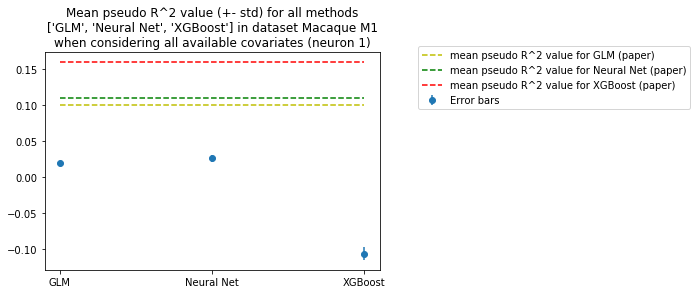

In [41]:
plot_error_bars(datasets[0])

I have tried to reproduce the results in Figure 5 of the paper above, page 8 of this [version](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6060269/pdf/fncom-12-00056.pdf). The results I have obtained are far worse than the ones shown in the paper. I think that the main issue with my results is that Hyperopt search (that is, the automatic exploration of values for parameters for each method) does not give as good results as manual parameter fine-tuning (increasing the number of trials, that is, *max_evals* to $50$ seem not to help).

If I do not apply the Hyperopt search, I obtain the same qualitative results as in the paper (although the mean pseudo R^2 values are still bad), with Gradient-boosted trees, and Neural Nets, performing far better than GLM.

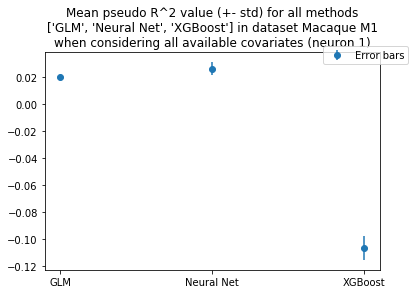

In [42]:
plot_error_bars2(datasets[0])

In [34]:
xgboost_model = MLencoding(tunemodel = 'xgboost', window = 10, n_filters = 2,
                           max_time = 250)

## Finetuning parameters for XGboost
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK

space4xgboost = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'gamma': hp.uniform('eta', 0.1, 1.0),
}

#function to minimize
def fnc_xgb(params, X, y):
    xgboost_model.set_params(params)
    Y_hat, PR2s = xgboost_model.fit_cv(X,y, n_cv = 5, verbose = 0)
    return -np.mean(PR2s)

results(3)

----------- Dataset #4
----------- GLM


IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
plot_error_bars2(datasets[2])